In [1]:
"""
Plot example image chunks from reference data
"""

import os, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torchsat.models.classification import resnet18
from torch.utils.data.dataloader import default_collate

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree

from fiona.crs import from_epsg

import warnings
warnings.filterwarnings("ignore")

plt.ion() # interactive

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [2]:
class RoofImageDataset_Planet(Dataset):
    """Class to handle PlanetScope SuperDove imagery for Resnet-18"""

    def __init__(self, gdf, img_path, n_bands=3, imgdim=64, transform=None):
        """
        Args:
            gdf: Geodataframe containing 'geometry' column and 'class_code' column
            img_path: the path to the PlanetScope SuperDove composite image (single mosaic file)
            imgdim (int): Image dimension for CNN implementation
            transform (callable, optional): Optional transform to be applied on a sample

        Returns image chunks with class labels
        """

        if not os.path.exists(img_path):
            raise ValueError(f'Image does not exists: {img_path}')

        self.geometries = [p.centroid for p in gdf.geometry.values]
        self.img = img_path
        self.image_dim = imgdim # resnet window dimension, defaults to 64
        self.n_bands = n_bands
        self.Y = gdf.code.values
        # Define transforms
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((self.image_dim, self.image_dim)),  # Resize to NxN for ResNet-18
                transforms.ToTensor()
            ])
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.geometries)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Sample the PlanetScope image
        geom = self.geometries[idx]

        try:
            sample = self.sample_image(geom)  # run the sampling function
            
            cc = self.Y[idx]  # get the class codes
            
            # Ensure the sample has the correct dimensions
            if sample.shape[1:] != (self.image_dim, self.image_dim):
                raise ValueError(f'Invalid sample shape: {sample.shape}')
                        
        except Exception as e:
            print(f"Skipping invalid sample at index {idx}: {e}")
            return None  # Return None for invalid samples
        
        # Convert the sample array to a Torch object
        sample = torch.from_numpy(sample)

        return {'image': sample.type(torch.FloatTensor),
                'code': torch.tensor(cc).type(torch.LongTensor)}
        
        
    def sample_image(self, geom):
        # Sample the image at each geometry
        samples = [] # store the samples in a list

        N = self.image_dim
            
        # Use the windows.from_bounds() method to return the window
        # Returns image chunks from training data locations
        with rio.open(self.img) as src:
            py, px = src.index(geom.x, geom.y)
            window = rio.windows.Window(px - N // 2, py - N // 2, N, N)
            
            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = src.read(window=window)

            # Handle the case where the sample is smaller than the expected size
            if clip.shape[1:] != (N, N):
                padding = [(0, 0), (0, max(0, N - clip.shape[1])), (0, max(0, N - clip.shape[2]))]
                clip = np.pad(clip, padding, mode='constant', constant_values=0)

            if clip.shape != (3, N, N):
                raise ValueError(f'Invalid sample shape: {clip.shape}')
            else:
                samples.append(clip)

            del clip, py, px, window

        # Convert the image chunk to a numpy array
        samples_arr = np.array(samples)

        del samples # Clear up memory

        # Make sure there is valid data
        if samples_arr.sum() > 0:
            ans = np.ma.masked_equal(samples_arr, 0).mean(axis=0)
        else:
            ans = samples_arr.mean(axis=0)

        del samples_arr

        return ans


def make_good_batch(batch):
    """
    Removes bad samples if image dimensions do not match.
    
    batch: list of dictionaries, each containing 'image' tensor and 'code' tensor
    
    returns: list of dictionaries same as input with samples having non-matching image dims removed
    """
    valid_samples = []

    for sample in batch:
        if sample is not None:
            image, code = sample['image'], sample['code']
            if code != 255 and not torch.isnan(code) and not torch.isinf(code):
                if not torch.isnan(image).any() and not torch.isinf(image).any():
                    if image.shape == (3, 64, 64):  # Ensure dimensions match
                        valid_samples.append(sample)
            del image, code

    if not valid_samples:
        return None

    return default_collate(valid_samples)
    del valid_samples, sample


def print_raster(raster,open_file):
    """
    :param raster: input raster file
    :param open_file: should the file be opened or not
    :return: print statement with raster information
    """
    if open_file is True:
        img = rxr.open_rasterio(raster,masked=True).squeeze()
    else:
        img = raster
    print(
        f"shape: {img.rio.shape}\n"
        f"resolution: {img.rio.resolution()}\n"
        f"bounds: {img.rio.bounds()}\n"
        f"sum: {img.sum().item()}\n"
        f"CRS: {img.rio.crs}\n"
        f"NoData: {img.rio.nodata}"
        f"Array: {img}"
    )
    del img


def plot_example_chunks(dataset, class_mapping, num_examples=3):
    """
    Plots example image chunks for each class.
    
    Args:
    - dataset: The dataset containing the image chunks and labels.
    - class_mapping: Dictionary mapping class codes to class labels.
    - num_examples: Number of examples to plot for each class.
    """
    
    classes = list(class_mapping.keys())
    fig, axes = plt.subplots(len(classes), num_examples, figsize=(10,10))
    # fig.suptitle("Example Image Chunks for Each Roof Class", fontsize=16)

    for i, cls in enumerate(classes):
        cls_indices = [j for j, x in enumerate(dataset.Y) if x == cls]
        
        if len(cls_indices) < num_examples:
            print(f"Not enough samples for class {cls}. Available samples: {len(cls_indices)}")
            continue
        
        selected_indices = np.random.choice(cls_indices, num_examples, replace=False)

        for k, idx in enumerate(selected_indices):
            sample = dataset[idx]
            if sample is None:
                print(f"Skipping invalid sample at index {idx}")
                continue
            image = sample['image'].permute(1, 2, 0).numpy()  # Change the dimensions to HWC for plotting
            
            # Scale the image to [0, 255] range for display
            image = (255 * (image - image.min()) / (image.max() - image.min())).astype(np.uint8)
            
            axes[i, k].imshow(image)
            axes[i, k].set_title(class_mapping[cls] if k == 0 else '')  # Title only on the first column
            axes[i, k].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    plt.savefig('image_chunks.png')
    plt.show()
    

print("Class and functions ready to use!")

Class and functions ready to use!


In [3]:
# Load the reference data
ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/reference_samples_pure.gpkg')
ref = gpd.read_file(ref_fp)
ref['code'], _ = pd.factorize(ref['class_code'])
ref.head()

,class_code,geometry,code
0,CS,POINT (324219.172 4313566.126),0
1,CS,POINT (327261.743 4300373.479),0
2,CS,POINT (333611.213 4306261.623),0
3,CS,POINT (326485.114 4300942.688),0
4,CS,POINT (331550.378 4305429.849),0


In [4]:
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['code'], ref['class_code']))
print(class_mapping)

{0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 4: 'TL', 5: 'WSH'}


In [5]:
# Split into train/test for each class
train_df, test_df, val_df = [], [], []

# Define split ratios
ts = 0.4  # Test size ratio
vs = 0.2  # Validation size ratio from remaining

# Perform initial stratified split to separate training data from test+validation data
train_df, temp_df = train_test_split(
    ref, # our filtered samples
    test_size=ts, 
    random_state=27, 
    stratify=ref['code']
)

# Perform stratified split on the temp_df to create validation and test sets
val_size = vs / (1 - ts)  # Adjust validation size to account for the initial split
val_df, test_df = train_test_split(
    temp_df, 
    test_size=val_size, 
    random_state=27, 
    stratify=temp_df['code']
)

# Print the class distribution in validation and test sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
1    17031
0    14621
2     4941
5      285
3      151
4      119
Name: count, dtype: int64
Validation class distribution:
 code
1    7569
0    6498
2    2196
5     127
3      67
4      53
Name: count, dtype: int64
Test class distribution:
 code
1    3785
0    3250
2    1098
5      63
3      34
4      26
Name: count, dtype: int64


In [6]:
# Define the path to the input image
stack_da_fp = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_data_psscene8b.tif')

# Load the image data
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()

# Extract metadata
with rio.open(stack_da_fp) as src:
    band_descriptions = src.descriptions  # This gives the long names of the bands

# Create the dictionary mapping long names to band numbers
band_dict = {band_descriptions[i]: i + 1 for i in range(len(band_descriptions))}

# Print the dictionary to verify
print(band_dict)

{'coastal_blue': 1, 'blue': 2, 'green_i': 3, 'green': 4, 'yellow': 5, 'red': 6, 'rededge': 7, 'nir': 8}


In [7]:
# Select the red, green, and blue bands
red_band = stack_da[band_dict['red'] - 1]  # subtract 1 because xarray is 0-indexed
green_band = stack_da[band_dict['green'] - 1]
blue_band = stack_da[band_dict['blue'] - 1]

# Stack the selected bands into an RGB image
rgb_image = np.stack([red_band, green_band, blue_band], axis=0)

# Save the RGB image
rgb_image_path = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_data_psscene_rgb.tif')

# Define the metadata including the long_name attribute
metadata = {
    'driver': 'GTiff',
    'height': rgb_image.shape[1],
    'width': rgb_image.shape[2],
    'count': 3,
    'dtype': rgb_image.dtype,
    'crs': stack_da.rio.crs,
    'transform': stack_da.rio.transform(),
    'compress': 'lzw'
}

with rio.open(rgb_image_path, 'w', **metadata) as dst:
    dst.write(rgb_image)
    dst.set_band_description(1, 'red')
    dst.set_band_description(2, 'green')
    dst.set_band_description(3, 'blue')
    
print("RGB image saved successfully!")

RGB image saved successfully!


In [8]:
# Load our image data to check on the format
rgb = rxr.open_rasterio(rgb_image_path, masked=True, cache=False).squeeze()
print_raster(rgb, open_file=False)
band_names = rgb.long_name
del stack_da

shape: (7555, 6046)
resolution: (3.0, -3.0)
bounds: (316269.0, 4295631.0, 334407.0, 4318296.0)
sum: 49939820544.0
CRS: EPSG:32618
NoData: NoneArray: <xarray.DataArray (band: 3, y: 7555, x: 6046)> Size: 548MB
[137032590 values with dtype=float32]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 48kB 3.163e+05 3.163e+05 ... 3.344e+05 3.344e+05
  * y            (y) float64 60kB 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('red', 'green', 'blue')


In [9]:
# Create the training samples with the RGB image

bs = 128

train_ds = RoofImageDataset_Planet(
    train_df[['geometry', 'code']], rgb_image_path, imgdim=128
)
train_loader = DataLoader(
    train_ds, 
    batch_size=bs, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=make_good_batch,
    pin_memory=True # for GPU
)
print("Data loaded!")

Data loaded!


Class mapping: {0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 4: 'TL', 5: 'WSH'}
Train DataFrame head:
      class_code                        geometry  code
39789         ME  POINT (325123.834 4312502.717)     1
60268         SL  POINT (320238.989 4313194.062)     2
20439         CS  POINT (327099.463 4312981.014)     0
47235         ME  POINT (326110.353 4308888.783)     1
55215         SL  POINT (318752.869 4312655.822)     2
Validation DataFrame head:
      class_code                        geometry  code
10304         CS  POINT (329023.052 4310597.087)     0
42557         ME   POINT (324789.39 4313945.519)     1
37197         ME  POINT (323533.248 4310615.481)     1
8267          CS  POINT (330399.413 4302854.913)     0
26164         ME  POINT (327640.809 4306457.284)     1
Test DataFrame head:
      class_code                        geometry  code
52652         ME  POINT (324132.182 4310786.793)     1
50392         ME  POINT (323726.521 4311718.259)     1
32035         ME  POINT (326694.09

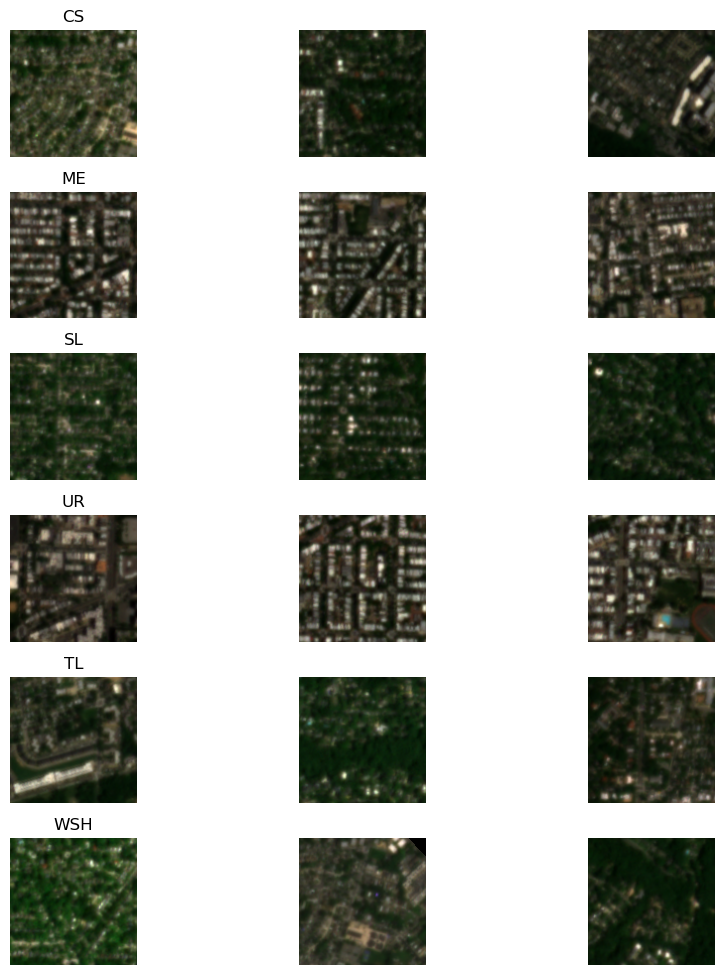

In [10]:
# Create a plot of example image chunks

# Ensure that train_df and other DataFrames have the numeric codes
ref['code'], class_mapping = pd.factorize(ref['class_code'])
class_mapping = dict(enumerate(class_mapping))
print("Class mapping:", class_mapping)

# Ensure train_df has the numeric codes
train_df = train_df.dropna(subset=['class_code'])
train_df['code'] = train_df['class_code'].map(lambda x: list(class_mapping.keys())[list(class_mapping.values()).index(x)])
val_df['code'] = val_df['class_code'].map(lambda x: list(class_mapping.keys())[list(class_mapping.values()).index(x)])
test_df['code'] = test_df['class_code'].map(lambda x: list(class_mapping.keys())[list(class_mapping.values()).index(x)])

# Verify the mapping
print("Train DataFrame head:")
print(train_df.head())
print("Validation DataFrame head:")
print(val_df.head())
print("Test DataFrame head:")
print(test_df.head())

# Plot example chunks
plot_example_chunks(train_ds, class_mapping, num_examples=3)